# IF240 - Machine learning and deep learning

## TP 2 - Naive Bayes classifier and evaluation metrics

By AurÃ©lie Bugeau and MichaÃ«l ClÃ©ment 

Credits: Vincent Lepetit, Varun Kumar, Mohit Deshpande

### Objectives 
The objective of the practice is to classifiy emails from a dataset as *spam* or *ham* (non-spam).

You will implement the Naive Bayes classifier, and test the model with several evaluation metrics.

In [1]:
import pandas as pd
import numpy as np
import math
import re
import string

## 1. Dataset

### Presentation and Loading

The dataset used here contained 747 *spam* and 4825 *ham* emails. 
Emails in the corpus have been already pre-processed in the following ways:

- Removal of stop words (and, the, of, etc)
- Lemmatization (variations of words such as *inludes*, *included*, *include* are now all considered as *include*)

In [2]:
# Open the dataset and count the number of spam/ham mails
mails = pd.read_csv("spamham.csv")
count = mails['Category'].value_counts()
print(count)
print(mails.head(), '\n')

ham     4825
spam     747
Name: Category, dtype: int64
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro... 



### Training and evaluation sets
Split the dataset into training and testing sets.

In [3]:
# Split data as training and testing sets
mask = np.random.rand(len(mails)) < 0.8
training_set = mails[mask]
testing_set = mails[~mask]

Take some time to study how to access the messages and categories for the dataset.

In [4]:
# COMPLETE
X_train = training_set['Message']
y_train = training_set['Category']
X_test = testing_set['Message']
y_test = testing_set['Category']
print(X_train)
print(y_train.value_counts())

0       Go until jurong point, crazy.. Available only ...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
5       FreeMsg Hey there darling it's been 3 week's n...
                              ...                        
5565                                         Huh y lei...
5566    REMINDER FROM O2: To get 2.50 pounds free call...
5567    This is the 2nd time we have tried 2 contact u...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Message, Length: 4388, dtype: object
ham     3795
spam     593
Name: Category, dtype: int64


## 2. Naive Bayes Classification

The classifier must be able to predict the label based on the text by implementing the following pseudo code, based on the bayesian decision rule:

`if (P(ham | message) > P(spam | message)) return ham else return spam`

where
\begin{align}
P(\text{ham} \,|\, message)  &= \text{Probability that the message is ham given its observed features} \\
P(\text{spam} \,|\, message) &= \text{Probability that the message is spam given its observed features}
\end{align}

The features will be based on the number of occurence of each word in the message.

(See the bag-of-words model: https://en.wikipedia.org/wiki/Bag-of-words_model)

### Question 1 

Apply the Naive Bayes formula in the following code to implement a classifier. With the naive assumption, we will consider that:

$$P(\text{message} \,|\, \text{spam}) = \prod_i P(w_i \,|\, \text{spam}) $$
where $w_i$ is the frequency of word $i$ in the message.
 
*Note:* if the vocabulary is large and if some words are very rare, we may encounter problems as $P(w_i\,|\,\text{ham})$ or $P(w_i\,|\,\text{spam})$ can be close to 0 for some $w_i$, therefore driving the product towards 0. This can also lead to numerical issues when the resulting probabilities are very small.
To solve this problem, it is convenient to apply $\log$ on both sides. We then have:

$$log(P(\text{message} \,|\, \text{spam})) = \sum_i log(P(w_i \,|\, \text{spam})) $$

But the problem is still not completely solved. If the classifier encounters a new word that is not present in a given category of our training set, or in the test set, then $P(w_i | \text{category})$ will be 0 and $log(0)$ is undefined. To solve this problem, we can use the so-called Laplace smoothing technique:

$$P(w_1 \,|\, \text{spam}) = \frac{\text{#occurrences of } w_i \text{ in spam} + 1}{\text{#words in spam}+ \text{#distinct words in training set}}$$


In [5]:
# Class for detecting spam using Naive Bayes
class SpamDetectorNB(object):
    
    def __init__(self):
        self.log_priors = {}
        self.word_counts = {}
        self.word_index = {}
        self.vocab = set()
    
    # Compute log class priors log(ð‘ƒ(â„Žð‘Žð‘š)) and log(ð‘ƒ(spð‘Žð‘š))  
    # by counting up how many spam/ham messages are in our dataset and dividing by the total number
    def compute_log_priors(self, X_train, y_train):
        # COMPLETE
        total_size = len(y_train)
        ham_size = y_train.value_counts()[0]
        spam_size = total_size - ham_size
        self.log_priors['spam'] = math.log(spam_size/total_size)
        self.log_priors['ham'] = math.log(ham_size/total_size)
    
    # Tokenize a string into words    
    def tokenize(self, text):
        return re.split("\W+", text)

    # Count how many times each word appears in a text. 
    # Returns a dictionary that contains for each word the number of times it appears in text. 
    def get_word_counts(self, text):
        text_tokenized = self.tokenize(text)
        word_counts = {i: text.count(i) for i in text_tokenized}
        return word_counts
    
    # Create a dictionary (a vocabulary of words)
    # and count words frequency for spam and ham separately
    def compute_word_frequencies(self, X_train, y_train):
        self.word_counts['spam'] = {}
        self.word_counts['ham'] = {}
        for text, label in zip(X_train, y_train):
            counts = self.get_word_counts(text)
            for word, count in counts.items():
                if word not in self.vocab:
                    self.word_index[word] = len(self.vocab)
                    self.vocab.add(word)
                if word not in self.word_counts[label]:
                    self.word_counts[label][word] = 0.0
                self.word_counts[label][word] += count
                
                
    # Compute all necessary features
    def train(self, X_train, y_train):
        self.compute_log_priors(X_train, y_train)
        self.compute_word_frequencies(X_train, y_train)
        
        
    def predict(self, X_test):
        predictions = []
        for text in X_test:
            # Compute word counts
            counts = self.get_word_counts(text)
            # Initialize log posteriors ð‘™ð‘œð‘”(ð‘ƒ(spam|message)) and ð‘™ð‘œð‘”(ð‘ƒ(ham|message)) according to log priors
            # COMPLETE
            log_P_spam_message = self.log_priors['spam']
            log_P_ham_message = self.log_priors['ham']
            # Update log posteriors with log likelihoods of each word
            for word, count in counts.items():     
                # Compute log likelihoods log(P(w|spam)) and log(P(w|ham))
                # COMPLETE
                log_word_spam = math.log(self.word_counts['spam'].get(word,0)+1)-math.log((len(self.word_counts['spam']) + len(self.vocab)))
                log_word_ham = math.log(self.word_counts['ham'].get(word,0)+1)-math.log((len(self.word_counts['ham']) + len(self.vocab)))
                # Update log posteriors
                # COMPLETE
                log_P_spam_message += log_word_spam
                log_P_ham_message += log_word_ham                
            # Apply the bayesian decision rule to classify spam or ham
            # COMPLETE
            if(log_P_spam_message < log_P_ham_message):
                predictions.append('ham')
            else:
                 predictions.append('spam')
        return predictions

In [6]:
# Apply the classifier to the spam dataset
sd = SpamDetectorNB()
sd.train(X_train, y_train)
#print(X_train)
#print(y_train)
result = sd.predict(X_test)
print(result)

['ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'spam', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ha

### Question 2 - Evaluation metrics and confusion matrix
Compute the precision, recall, accuracy and confusion matrix

In [7]:
def numbers():
    nb_tp = 0
    nb_fp = 0
    nb_fn = 0
    nb_tn = 0
    for i,j in zip(y_test,result):
        if(i == "spam" and j == "spam"):
            nb_tp+=1
        elif(i == "ham" and j == "spam"):
            nb_fp+=1
        elif(i == "spam" and j == "ham"):
            nb_fn+=1
        elif(i == "ham" and j == "ham"):
            nb_tn+=1
    return nb_tp, nb_fp,nb_fn,nb_tn

nb_tp,nb_fp,nb_fn,nb_tn = numbers()

precision = nb_tp/(nb_tp+nb_fp)

recall = nb_tp/(nb_tp+nb_fn)

accuracy = (nb_tp+nb_tn)/(nb_tp+nb_fp+nb_fn+nb_tn)

# COMPLETE
print("Precision: {0:.4f}".format(precision))
print("Recall: {0:.4f}".format(recall))
print("Accuracy : {0:.4f}".format(accuracy))
print("Confusion matrix using SpamDetectorNB:")
print("              Present   Not present")
print("Detected      ",nb_tp,"        ", nb_fp)
print("Not detected  ",nb_fn,"        ", nb_tn)

Precision: 0.9921
Recall: 0.8182
Accuracy : 0.9755
Confusion matrix using SpamDetectorNB:
              Present   Not present
Detected       126          1
Not detected   28          1029


### Question 3 - Naive Bayes with Scikit-learn library
The `scikit-learn` library proposes many functions for machine learning.  Study the documentation of the  `MultinomialNB` class and apply it for spam detection.

You will need to convert the dataset into arrays and to normalize the word counts into frequencies.

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#converting the dataset into arrays 
vectorizer = CountVectorizer()
features = vectorizer.fit_transform(mails['Message']).toarray()

#creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
mails_encoded=le.fit_transform(mails['Category'])

# split train and test sets
x_train, x_test, y_train, y_test = train_test_split(features, mails_encoded, random_state=0)

#Creating naive bayes classifier 
model = MultinomialNB()

# Train the model using the training sets
model.fit(x_train, y_train)

#Predict Output
y_predicted= model.predict(x_test)


### Question 4 - Evaluation with Scikit-learn library

The `scikit-learn` library also proposes  functions to evaluate machine learning methods.

Apply them to the spam detection problem.

accuracy: 0.9806
Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1208
        spam       0.92      0.93      0.93       185

    accuracy                           0.98      1393
   macro avg       0.96      0.96      0.96      1393
weighted avg       0.98      0.98      0.98      1393

Confusion matrix using MultinomialNB:


<AxesSubplot:>

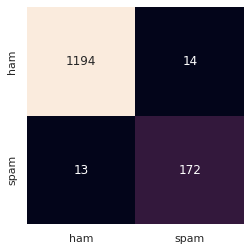

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

#visualisation of the accuracy
accuracy = accuracy_score(y_test, y_predicted)
print("accuracy: {0:.4f}".format(accuracy))

#visualisation of the classification report
print("Report:")
print(metrics.classification_report(y_test, y_predicted,target_names=mails['Category'].unique()))

#visualisation of the confusion matrix
print("Confusion matrix using MultinomialNB:")
matrix = confusion_matrix(y_test, y_predicted)
import seaborn as sns; sns.set()  # for plot styling
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False\
            , xticklabels = ['ham', 'spam'],yticklabels = ['ham', 'spam'])